# Interpretable Decompositions

[Time series signal decomposition](https://en.wikipedia.org/wiki/Decomposition_of_time_series) involves breaking down an original time series into its constituent components. By decomposing the time series, we can gain insights into underlying patterns, trends-cycles, and seasonal effects, enabling improved understanding and forecasting accuracy.

This notebook will show how to use the `NHITS`/`NBEATSx` to extract these series' components. We will:<br>
- Installing NeuralForecast.<br>
- Simulate a Harmonic Signal.<br>
- NHITS' forecast decomposition.<br>
- NBEATSx' forecast decomposition.<br>

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/Signal_Decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing NeuralForecast

In [ ]:
%%capture
!pip install neuralforecast

## 2. Simulate a Harmonic Signal

In this example, we will consider a Harmonic signal comprising two frequencies: one low-frequency and one high-frequency.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
N = 10_000
T = 1.0 / 800.0 # sample spacing
x = np.linspace(0.0, N*T, N, endpoint=False)

y1 = np.sin(10.0 * 2.0*np.pi*x) 
y2 = 0.5 * np.sin(100 * 2.0*np.pi*x)
y = y1 + y2

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"]=True

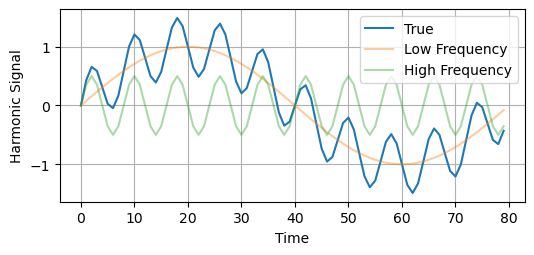

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2.5))
plt.plot(y[-80:], label='True')
plt.plot(y1[-80:], label='Low Frequency', alpha=0.4)
plt.plot(y2[-80:], label='High Frequency', alpha=0.4)
plt.ylabel('Harmonic Signal')
plt.xlabel('Time')
plt.legend()
plt.show()
plt.close()

In [ ]:
# Split dataset into train/test
# Last horizon observations for test
horizon = 96
Y_df = pd.DataFrame(dict(unique_id=1, ds=np.arange(len(x)), y=y))
Y_train_df = Y_df.groupby('unique_id').head(len(Y_df)-horizon)
Y_test_df = Y_df.groupby('unique_id').tail(horizon)
Y_test_df

,unique_id,ds,y
9904,1,9904,-0.951057
9905,1,9905,-0.570326
9906,1,9906,-0.391007
9907,1,9907,-0.499087
9908,1,9908,-0.809017
...,...,...,...
9995,1,9995,-0.029130
9996,1,9996,-0.309017
9997,1,9997,-0.586999
9998,1,9998,-0.656434


## 3. NHITS decomposition

We will employ `NHITS` stack-specialization to recover the latent harmonic functions. 

`NHITS`, a Wavelet-inspired algorithm, allows for breaking down a time series into various scales or resolutions, aiding in the identification of localized patterns or features. The expressivity ratios for each layer enable control over the model's stack specialization.

In [ ]:
from neuralforecast.models import NHITS, NBEATSx
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import HuberLoss, MQLoss

In [ ]:
%%capture
models = [NHITS(h=horizon,                           # Forecast horizon
                input_size=2 * horizon,              # Length of input sequence
                loss=HuberLoss(),                    # Robust Huber Loss
                max_steps=1000,                      # Number of steps to train
                dropout_prob_theta=0.5,
                interpolation_mode='linear',
                stack_types=['identity']*2,
                n_blocks=[1, 1],
                mlp_units=[[64, 64],[64, 64]],
                n_freq_downsample=[10, 1],           # Inverse expressivity ratios for NHITS' stacks specialization
                val_check_steps=10,                  # Frequency of validation signal (affects early stopping)
              )
          ]
nf = NeuralForecast(models=models, freq=1)
nf.fit(df=Y_train_df)

In [ ]:
from neuralforecast.tsdataset import TimeSeriesDataset

# NHITS decomposition plot
model = nf.models[0]
dataset, *_ = TimeSeriesDataset.from_df(df = Y_train_df)
y_hat = model.decompose(dataset=dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

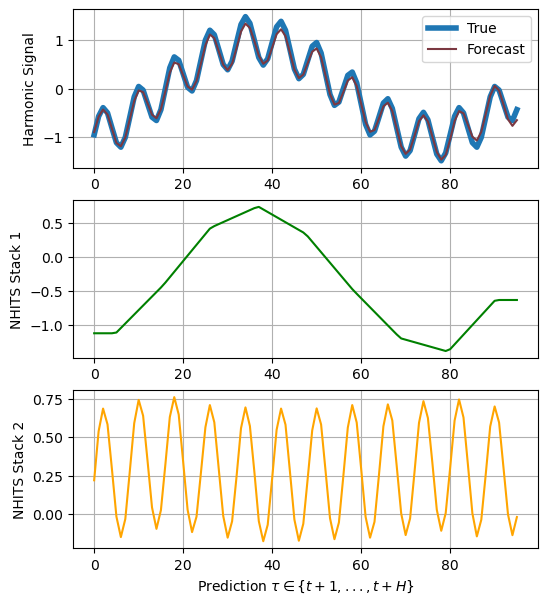

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(6, 7))

ax[0].plot(Y_test_df['y'].values, label='True', linewidth=4)
ax[0].plot(y_hat.sum(axis=1).flatten(), label='Forecast', color="#7B3841")
ax[0].legend()
ax[0].set_ylabel('Harmonic Signal')

ax[1].plot(y_hat[0,1]+y_hat[0,0], label='stack1', color="green")
ax[1].set_ylabel('NHITS Stack 1')

ax[2].plot(y_hat[0,2], label='stack2', color="orange")
ax[2].set_ylabel('NHITS Stack 2')
ax[2].set_xlabel(r'Prediction $\tau \in \{t+1,..., t+H\}$')
plt.show()

## 4. NBEATSx decomposition

Here we will employ `NBEATSx` interpretable basis projection to recover the latent harmonic functions. 

`NBEATSx`, this network in its interpretable variant sequentially projects the signal into polynomials and harmonic basis to learn trend $T$ and seasonality $S$ components:
$$\hat{y}_{[t+1:t+H]} = \theta_{1} T + \theta_{2} S$$ 

In contrast to `NHITS`' wavelet-like projections the basis heavily determine the behavior of the projections. And the Fourier projections are not capable of being immediately decomposed into individual frequencies.

In [ ]:
%%capture
models = [NBEATSx(h=horizon,                           # Forecast horizon
                  input_size=2 * horizon,              # Length of input sequence
                  loss=HuberLoss(),                    # Robust Huber Loss
                  max_steps=1000,                      # Number of steps to train
                  dropout_prob_theta=0.5,
                  stack_types=['trend', 'seasonality'], # Harmonic/Trend projection basis
                  n_polynomials=0,                      # Lower frequencies can be captured by polynomials
                  n_blocks=[1, 1],
                  mlp_units=[[64, 64],[64, 64]],
                  val_check_steps=10,                  # Frequency of validation signal (affects early stopping)
              )
          ]
nf = NeuralForecast(models=models, freq=1)
nf.fit(df=Y_train_df)

In [ ]:
# NBEATSx decomposition plot
model = nf.models[0]
dataset, *_ = TimeSeriesDataset.from_df(df = Y_train_df)
y_hat = model.decompose(dataset=dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

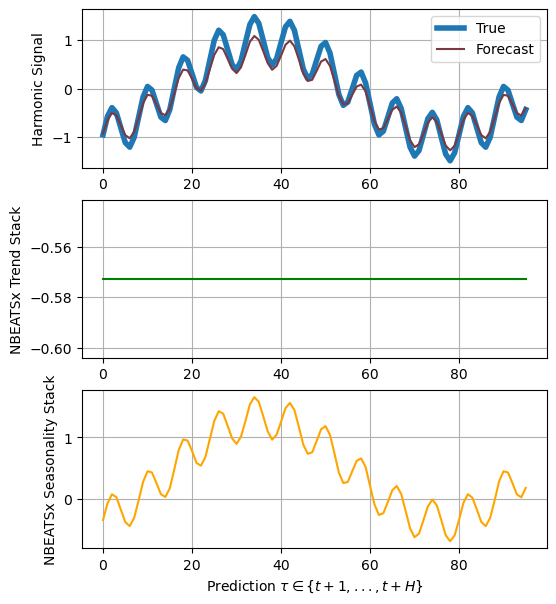

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(6, 7))

ax[0].plot(Y_test_df['y'].values, label='True', linewidth=4)
ax[0].plot(y_hat.sum(axis=1).flatten(), label='Forecast', color="#7B3841")
ax[0].legend()
ax[0].set_ylabel('Harmonic Signal')

ax[1].plot(y_hat[0,1]+y_hat[0,0], label='stack1', color="green")
ax[1].set_ylabel('NBEATSx Trend Stack')

ax[2].plot(y_hat[0,2], label='stack2', color="orange")
ax[2].set_ylabel('NBEATSx Seasonality Stack')
ax[2].set_xlabel(r'Prediction $\tau \in \{t+1,..., t+H\}$')
plt.show()

## References

- [Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2023). NHITS: Neural Hierarchical Interpolation for Time Series Forecasting.](https://arxiv.org/abs/2201.12886)<br>
- [Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio (2019). "N-BEATS: Neural basis expansion analysis for interpretable time series forecasting".](https://arxiv.org/abs/1905.10437)<br>
- [Kin G. Olivares, Cristian Challu, Grzegorz Marcjasz, Rafał Weron, Artur Dubrawski (2021). "Neural basis expansion analysis with exogenous variables: Forecasting electricity prices with NBEATSx".](https://arxiv.org/abs/2104.05522)